In [26]:
import pymongo
import pandas as pd
#from pandas import Series
import numpy as np
np.set_printoptions(threshold='nan')
from numpy.linalg import inv
from scipy import signal
from scipy.io import wavfile
import soundfile as sf
import matplotlib.pyplot as plt
%matplotlib inline
#from collections import Counter
from bson.objectid import ObjectId
import json
import pprint
from pydub import AudioSegment
import urllib
import fnmatch
import os
import requests
import ffmpy
import subprocess
import librosa
import librosa.display
import time

In [27]:
client = pymongo.MongoClient('localhost',27017)
#client = pymongo.MongoClient('localhost',32768)
db = client.get_database('b=bandhub')

In [28]:
songCol = db.get_collection('songsStream')
vidCol = db.get_collection('mergedVideos')
trackCol = db.get_collection('tracksStream')
postCol = db.get_collection('posts')
[songCol.count(), vidCol.count(), trackCol.count(), postCol.count()]

[425706, 198169, 915582, 494867]

Generate mixes with "num_track" public, published tracks, where num_track > 3

In [29]:
def get_published_tracks(num_track):
    pub_tracks = postCol.find({'songAccess':{'$exists': True}}, {'participantsInfo':1 ,'songAccess':1, 'objectId':1})
    for docs in pub_tracks:
        if(docs['songAccess'] == 1):
            if(len(docs['participantsInfo']['publishedTracks']) == num_track):
                yield docs

Storing identifiers of the mixes with "num_track" public, published tracks that contain multiple mixing coefficients associated with the same mix

In [49]:
def get_processed_audio_ids(num_track):
    pub_docs = [x for x in get_published_tracks(num_track)]
    count_mixes = len(pub_docs)
    print("Number of mixes with " + str(num_track) + " public, published tracks: " + str(count_mixes))
    missing_song_id = []
    missing_pubtrack = []
    index_required = []
    pub_songs = []
    for j in range(count_mixes):
        pub_tracks = []
        remix_test = pub_docs[j]['_id']
        song_id = pub_docs[j]['objectId']
        
        song_look_up = songCol.find({'masterSongId' : song_id})
        
        for i in range(num_track):
            pub_tracks.append(pub_docs[j]['participantsInfo']['publishedTracks'][i]['_id'])
                                
        if song_look_up is -1:
            missing_song_id.append(song_id)
            pprint.pprint('Error: SongID not found in Song Collection!')
        else:
            for song_docs in song_look_up:
                for i in range(len(pub_tracks)):
                    if(str(pub_tracks[i]) not in song_docs['settings']):
                        missing_pubtrack.append(pub_tracks[i])   
                        break
                    else:
                        if ('volume' in song_docs['settings'][str(pub_tracks[i])]['audioChannels'][0] and 'volume' in song_docs['settings'][str(pub_tracks[i])]):
                            if (round(song_docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'],2) != round(song_docs['settings'][str(pub_tracks[i])]['volume'],2)):
                                index_required.append(j)
                                pub_songs.append([remix_test,song_id])
                                break
                            else:
                                continue
                        else:
                            #print('Mixing coefficient missing')
                            break

    return pub_songs
 

Get filename w/ extension from file URL

In [31]:
def get_filename(file):
    filePath = file.split('/')
    return filePath[- 1]

Get the following mixing coefficients for the mixes with multiple mixing coefficients<br>
Returns: 
         * Volume from settings
         * Volume from channels
         * Track filenames
         * Track start times

In [62]:
def get_mixing_coeff(num_track, song_id, track_id):
    
    pub_t_vol = []
    pub_t_vol_ch = []
    ogg_paths = []
    start_times = []
    track_filenames = []
    pub_tracks = []

    song_doc = songCol.find({'masterSongId' : song_id})
    post_doc = postCol.find({'_id' : track_id})
    
    for docs in post_doc:
        for i in range(num_track):
            pub_tracks.append(docs['participantsInfo']['publishedTracks'][i]['_id'])
    
    for docs in song_doc:    
        for i in range(len(pub_tracks)):
            if(str(pub_tracks[i]) in docs['settings']):
                pub_t_vol.append(round(docs['settings'][str(pub_tracks[i])]['volume'],2))
                if ('volume' in docs['settings'][str(pub_tracks[i])]['audioChannels'][0]):
                    pub_t_vol_ch.append(round(docs['settings'][str(pub_tracks[i])]['audioChannels'][0]['volume'],2))
                else:
                    pub_t_vol_ch.append(round(docs['settings'][str(pub_tracks[i])]['volume'],2))
            
                gettrack = trackCol.find({'_id' : pub_tracks[i]})
                for tdocs in gettrack:
                    start_times.append(tdocs['startTimeValue'])
                    if('effectsAudioUrl' in docs['settings'][str(pub_tracks[i])]):
                        ogg_paths.append(docs['settings'][str(pub_tracks[i])]['effectsAudioUrl'])
                    else:
                        ogg_paths.append(tdocs['audioChannels'][0]['fileUrl'])
            else:
                print('Missing published track!')
        
    return pub_t_vol, pub_t_vol_ch, ogg_paths, start_times

Set the download path to a subfolder in the scratch folder

In [33]:
def set_path():
    path = '/scratch/rrs432/tracks'
    os.chdir(path)

Download track using filepath

In [34]:
def download_track(ogg_path):
    
    set_path()

    r = requests.get(ogg_path)
    filename = get_filename(ogg_path)
    with open(filename, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)

Clear previous downloads in aforementioned folder

In [35]:
def clear_downloads():
    ! rm -rf *.ogg *.wav

Set all tracks to an identical stereo length, which is that of the longest track

In [36]:
def match_track_lengths(num_track,track_filenames):
    ogg_tracks = []
    track_lens = []
    sam_rate = []
    for i in range(num_track):
        track, fs = sf.read('/scratch/rrs432/tracks/'+track_filenames[i])
        sam_rate.append(fs)
        track_lens.append(track.shape[0])
        #Convert mono to stereo
        if track.ndim is not 2:
            track = np.stack((track, track), axis = 1)
        ogg_tracks.append(track)

    if (min(sam_rate) == max(sam_rate)):
        mixsr = sam_rate[0] 
    else:
        pprint.pprint('Warning: Sample rates unequal')
    pprint.pprint(mixsr)
    
    master_track_len = max(track_lens)
    
    for i in range(num_track):
        diff = np.zeros(((master_track_len - track_lens[i]),2))
        ogg_tracks[i] = np.vstack((ogg_tracks[i], diff))
        pprint.pprint(np.shape(ogg_tracks[i]))
    
    return ogg_tracks, mixsr

Set all mixes to an identical stereo length, which is that of the longer mix

In [37]:
def match_mix_lengths(mix1,mix2):
    if len(mix1) > len(mix2):
        diff_len = np.zeros(((len(mix1)-len(mix2)),2))
        mix2 = np.vstack((mix2, diff_len))
    else:
        diff_len = np.zeros(((len(mix2)-len(mix1)),2))
        mix1 = np.vstack((mix1, diff_len))
    return mix1, mix2

Compute the estimated mix using specific mixing coefficients

In [38]:
def compute_estimated_mix(num_track, vol, tracks, fs):
    mix_ogg = 0
    for i in range(num_track):
        mix_ogg += (vol[i]*np.array(tracks[i]))
    return mix_ogg

Compensate for the offset introduced due to the stripping of audio from the mix video

In [39]:
def compute_offset_and_shift(estimated_mix, bandhub_mix):
    if(len(estimated_mix) < len(bandhub_mix)):
        flag = -1
    estimated_mix, bandhub_mix = match_mix_lengths(estimated_mix, bandhub_mix)
    correlation = np.correlate(bandhub_mix[:mixsr,1], estimated_mix[:mixsr,1], 'full')
    #plt.plot(correlation)
    
    offset = np.argmax(correlation, axis=None)
    offset = (2*mixsr - 1)/2 - offset
    if offset is not 0:
        if flag is -1:
            estimated_mix = np.roll(estimated_mix, -offset)
        else:
            bandhub_mix = np.roll(bandhub_mix, -offset)

    sf.write('estimix.wav', estimated_mix, mixsr)
    sf.write('bandmix.wav', bandhub_mix, mixsr)
    
    estimated_mix_spec, sr = librosa.load('estimix.wav', sr=mixsr)
    bandhub_mix_spec, sr = librosa.load('bandmix.wav', sr=mixsr)
    
    print(np.shape(bandhub_mix_spec))
    print(np.shape(estimated_mix_spec))
    
    return estimated_mix_spec,bandhub_mix_spec

Plots difference spectograms between bandhub's mix and the estimated mix

In [40]:
def plot_diff_spectrogram(estimated_mix_spec,bandhub_mix_spec): 
    bandhub_mix_data = librosa.amplitude_to_db(librosa.stft(bandhub_mix_spec), ref=np.max)
    estimated_mix_data = librosa.amplitude_to_db(librosa.stft(estimated_mix_spec), ref=np.max)
    diff_mix_data = abs(np.subtract(bandhub_mix_data,estimated_mix_data))

    plt.figure(figsize=(12, 3))
    librosa.display.specshow(diff_mix_data, y_axis='linear')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Diff Spectrogram')
    
    return round(np.mean((diff_mix_data)**2),2)

Main script

In [50]:
set_path()
clear_downloads()

num_track = 6

proc_id = get_processed_audio_ids(num_track)

pprint.pprint(proc_id)

Number of mixes with 6 public, published tracks: 3165
[[ObjectId('546f0ca14e5d9e60267e63ed'), ObjectId('52476d47bf9d3bda1e000016')],
 [ObjectId('546f0ca14e5d9e60267e63ed'), ObjectId('52476d47bf9d3bda1e000016')],
 [ObjectId('546f0cca4e5d9e60267e6564'), ObjectId('522628568e4448a274000002')]]


In [56]:
track_id = proc_id[0][0]
song_id = proc_id[0][1]
print(track_id)
print(song_id)

546f0ca14e5d9e60267e63ed
52476d47bf9d3bda1e000016


In [63]:
track_filenames = []

track_id = proc_id[0][0]
song_id = proc_id[0][1]

volume_settings, volume_channels, ogg_paths, start_times = get_mixing_coeff(num_track, song_id, track_id)

pprint.pprint(volume_settings)
pprint.pprint(volume_channels)
print('============')

for i in range(num_track):
    download_track(ogg_paths[i])
    track_filenames.append(get_filename(ogg_paths[i]))
    
pointer = vidCol.find({'songId': song_id})
for songdocs in pointer:
    bandhub_mix = songdocs['oggMergedVideoUrl']

download_track(bandhub_mix)

print('Downloads complete')
print('============')
!ls
print('============')

Missing published track!
Missing published track!
Missing published track!
[0.77, 0.7, 0.44, 0.26, 0.44, 1.0, 0.0, 0.92, 0.59]
[1.0, 0.7, 0.44, 0.26, 0.44, 1.0, 1.0, 0.7, 0.59]
Downloads complete
2386ad89-0260-4d91-8f1d-5dca6aac8e01.ogg
37cb423e-cb76-4e9f-826c-60f6c17464c5.ogg
53ea646a-ddd6-446b-b394-775687ccab0e.ogg
755beee2-4e23-4157-9967-8892bda7bd30.ogg
d9410c51-2a64-474b-9c52-23db351edb5d.ogg
e4847cbb-3d98-4119-bb91-8103c2302362.ogg
f-394becb2-05a0-4dba-96bd-46c25c2475e9.ogg


In [64]:
ogg_tracks, mixsr = match_track_lengths(num_track,track_filenames)

for premix in os.listdir('.'):
    if fnmatch.fnmatch(premix, 'f-*'):
        rename_cmd = ['mv', premix, 'premix.ogg']
        s = subprocess.call(rename_cmd)
        if s is 0:
            print('success')
            
convert_cmd = ['ffmpeg', '-i', 'premix.ogg', '-vsync', '1', '-async', '1', '-vn', 'premix.wav']
subprocess.call(convert_cmd)

mix_ogg = compute_estimated_mix(num_track, volume_settings, ogg_tracks, mixsr)
sf.write('mixed.wav', mix_ogg / np.max(np.abs(mix_ogg)), mixsr)

mix_ogg_ch = compute_estimated_mix(num_track, volume_channels, ogg_tracks, mixsr)
sf.write('mixed_ch.wav', mix_ogg_ch / np.max(np.abs(mix_ogg_ch)), mixsr)

44100
(10740928, 2)
(10740928, 2)
(10740928, 2)
(10740928, 2)
(10740928, 2)
(10740928, 2)
success


In [65]:
!ls

2386ad89-0260-4d91-8f1d-5dca6aac8e01.ogg
37cb423e-cb76-4e9f-826c-60f6c17464c5.ogg
53ea646a-ddd6-446b-b394-775687ccab0e.ogg
755beee2-4e23-4157-9967-8892bda7bd30.ogg
d9410c51-2a64-474b-9c52-23db351edb5d.ogg
e4847cbb-3d98-4119-bb91-8103c2302362.ogg
mixed_ch.wav
mixed.wav
premix.ogg
premix.wav


(11025856,)
(11025856,)
(11025856,)
(11025856,)
RMSE for estimated mix using volume from settings: 212.9
RMSE for estimated mix using volume from channels: 225.93


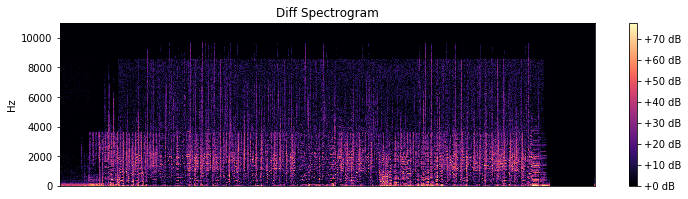

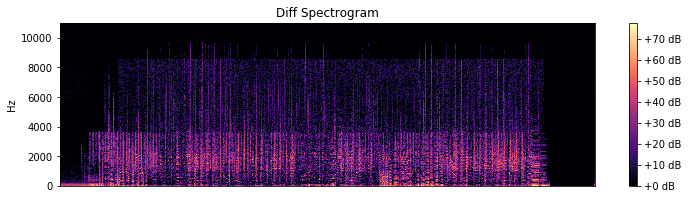

In [66]:
flag = 0
estimated_mix_ch, sr = sf.read('mixed_ch.wav')
estimated_mix, sr = sf.read('mixed.wav')
bandhub_mix, sr = sf.read('premix.wav')
# if(len(estimated_mix) < len(bandhub_mix)):
#     flag = -1
estimated_mix_spec,bandhub_mix_spec = compute_offset_and_shift(estimated_mix, bandhub_mix)
estimated_mix_ch_spec,bandhub_mix_spec = compute_offset_and_shift(estimated_mix_ch, bandhub_mix)

root_mean_sq_error = plot_diff_spectrogram(estimated_mix_spec,bandhub_mix_spec)
print('RMSE for estimated mix using volume from settings: '+str(root_mean_sq_error))
root_mean_sq_error = plot_diff_spectrogram(estimated_mix_ch_spec,bandhub_mix_spec)
print('RMSE for estimated mix using volume from channels: '+str(root_mean_sq_error))